In [12]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("YelpUserAnalysis") \
    .getOrCreate()

In [ ]:
reviews_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")

In [14]:
users_df = spark.read.json("path to.../yelp_dataset/yelp_academic_dataset_user.json")

In [15]:
arizona_businesses_df = spark.read.parquet("path to.../temp/arizona_businesses.parquet")

24/11/24 01:43:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [16]:
# Filter for businesses in the chosen category (e.g., Restaurants)
category_reviews_df = reviews_df.join(arizona_businesses_df, reviews_df.business_id == arizona_businesses_df.business_id) \
                                .filter(arizona_businesses_df["categories"].contains("Gyms"))

category_reviews_df.show(5)


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------+----------+------------+---------------+-----------+------------+-----+-----+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|             address|          attributes|         business_id|          categories|      city|               hours|is_open|  latitude|   longitude|           name|postal_code|review_count|stars|state|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------+----------+------------+---------------+-----------+------------+-----+-----+
|fpQEKd

In [17]:
# Join reviews with user data
user_reviews_df = category_reviews_df.join(users_df, category_reviews_df.user_id == users_df.user_id)

# Display the first few rows
user_reviews_df.show(5)


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+---------------+--------------------+--------------------+--------------------+------+--------------------+-------+-------------+---------------+-------------+-----------+------------+-----+-----+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+--------------------+----+--------------------+-----+-----+------------+------+--------------------+-------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|        address|          attributes|         business_id|          categories|  city|               hours|is_open|     latitude|      longitude|         name|postal_code|review_count|stars|state|average_stars|compliment_c

In [18]:
# Alias the DataFrames to avoid ambiguity
reviews_df = reviews_df.alias("reviews")
users_df = users_df.alias("users")

# Join reviews with user data, specifying the columns explicitly to avoid ambiguity
user_reviews_df = reviews_df.join(users_df, reviews_df["user_id"] == users_df["user_id"], "inner") \
    .select(reviews_df["user_id"], users_df["name"], reviews_df["text"], reviews_df["business_id"], users_df["review_count"])

# Show the first few rows to verify
user_reviews_df.show(5)

+--------------------+----+--------------------+--------------------+------------+
|             user_id|name|                text|         business_id|review_count|
+--------------------+----+--------------------+--------------------+------------+
|--6lqYpHZCBbpW5z2...|Jeff|Honestly was only...|mUI4DJagyUyu76qnR...|           9|
|--Kwhcbkh7jxkhVVQ...|Larz|The place is abso...|ORL4JE6tz3rJxVqkd...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|Ate dinner there ...|tIvfmgT1qMeAEQf8C...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|It was okay. If y...|Ld805G25xHALqbBo1...|          58|
|--Kwhcbkh7jxkhVVQ...|Larz|Went for a nice l...|arQfMJal1tl67Z96R...|          58|
+--------------------+----+--------------------+--------------------+------------+
only showing top 5 rows



In [19]:
category_reviews_df.createOrReplaceTempView("category_review")
user_reviews_df.createOrReplaceTempView("user")
reviews_df.createOrReplaceTempView("review")

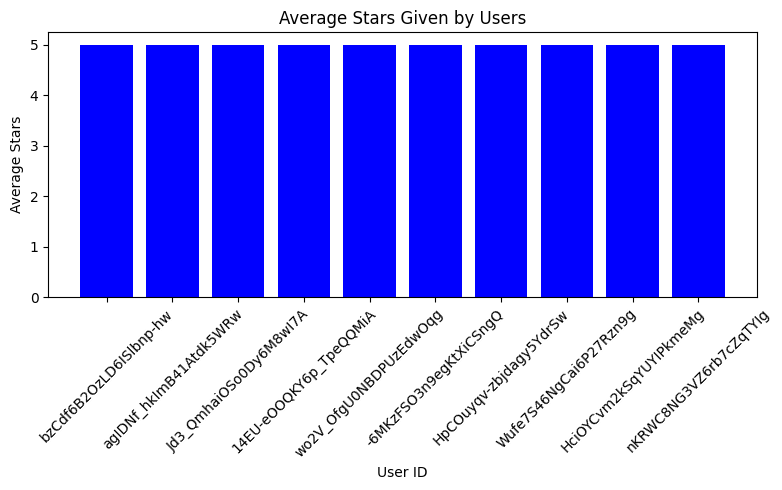

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Query 1: Average Stars Given by Users
query1 = """
SELECT r.user_id, AVG(r.stars) AS avg_stars
FROM review r
GROUP BY r.user_id
ORDER BY avg_stars DESC
LIMIT 10
"""
avg_stars_df = spark.sql(query1)

avg_stars_pandas = avg_stars_df.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(avg_stars_pandas['user_id'], avg_stars_pandas['avg_stars'], color='blue')
plt.title('Average Stars Given by Users')
plt.xlabel('User ID')
plt.ylabel('Average Stars')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

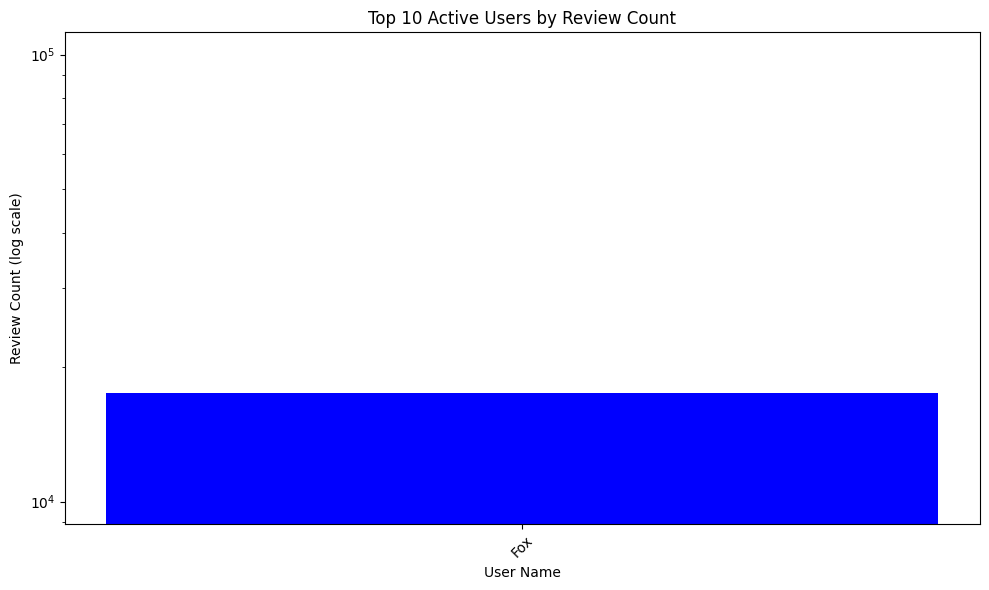

In [27]:
# Query 2: Top 10 Active Users by Review Count'


query2 = """
SELECT name, review_count
FROM user
ORDER BY review_count DESC
LIMIT 10
"""

# Convert the Spark DataFrame to Pandas
top_users_df = spark.sql(query2).toPandas()

# Plot the top 10 users by review count with log scaling on y-axis
plt.figure(figsize=(10, 6))
plt.bar(top_users_df['name'], top_users_df['review_count'], color='blue')
plt.yscale('log')
plt.title('Top 10 Active Users by Review Count')
plt.xlabel('User Name')
plt.ylabel('Review Count (log scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
# Filter for Gym businesses in Arizona
gyms_df = arizona_businesses_df.filter(arizona_businesses_df["categories"].contains("Gyms"))

gyms_df.show(5)
gyms_df.printSchema()

gyms_df.createOrReplaceTempView("Gyms")

+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|        city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|439 N 6th Ave, St...|{null, null, null...|eK-_ahKKaMUQ1b0F1...|Fitness & Instruc...|      Tucson|{6:0-17:30, 6:0-1...|      1|32.2273361255|-110.9688632562|         Let's Sweat|      85705|          55|  5.0|   AZ|
|8235 N Silverbell...|{null, null, null...|vj1NNfjAZkQv61fqD...|Fitness & Instruc...|      Tucson|{17:0-18:30, 17:0...|      1|   32.356

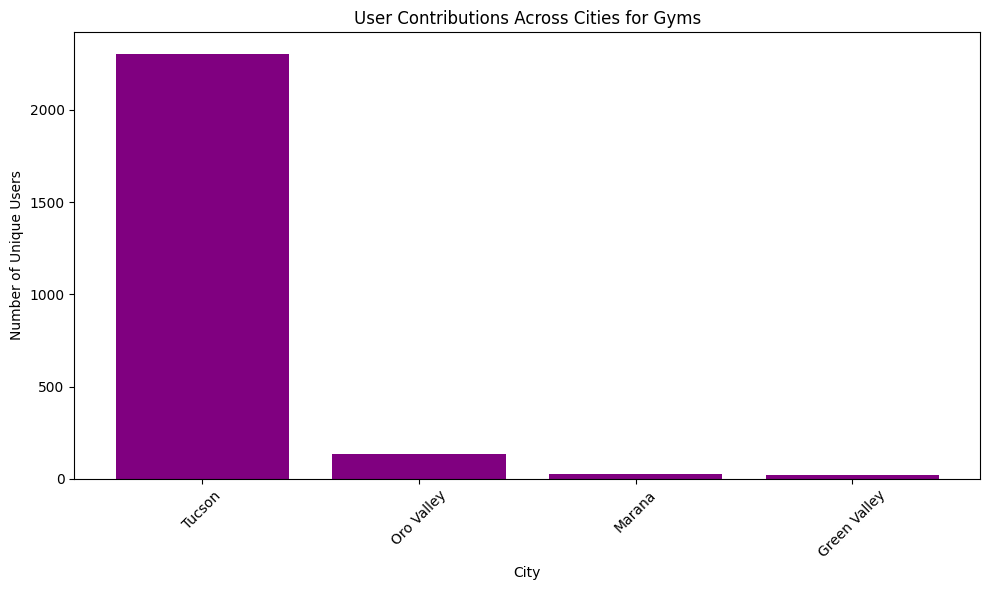

In [29]:
# Query 3: User Contributions Across Cities
query3 = """
SELECT g.city, COUNT(DISTINCT r.user_id) AS user_count
FROM review r
JOIN Gyms g ON r.business_id = g.business_id
GROUP BY g.city
ORDER BY user_count DESC
LIMIT 10
"""
user_city_contributions_df = spark.sql(query3)

user_city_contributions_pandas = user_city_contributions_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(user_city_contributions_pandas['city'], user_city_contributions_pandas['user_count'], color='purple')
plt.title('User Contributions Across Cities for Gyms')
plt.xlabel('City')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
users_df.createOrReplaceTempView("user")

reviews_df.printSchema()
users_df.printSchema()


user_reviews_df = reviews_df.join(users_df, "user_id")
user_reviews_df.show(5)


root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)

+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+-------+------------+------+-------------------+
|             user_id|         business_id|cool|               date|funny|           review_id|stars|                text|useful|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|             friends|funny|   name|review_count|useful|      yelping_since|
+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+-------------+---------------+---

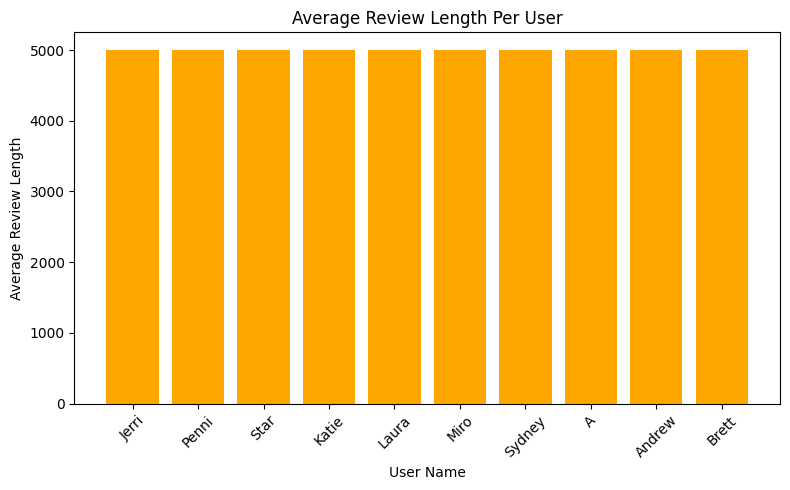

In [31]:
# Query 4: Average Review Length Per User
query4 = """
SELECT r.user_id, u.name, AVG(LENGTH(r.text)) AS avg_review_length
FROM review r
JOIN user u ON r.user_id = u.user_id
GROUP BY r.user_id, u.name
ORDER BY avg_review_length DESC
LIMIT 10
"""
avg_review_length_df = spark.sql(query4)

avg_review_length_pandas = avg_review_length_df.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(avg_review_length_pandas['name'], avg_review_length_pandas['avg_review_length'], color='orange')
plt.title('Average Review Length Per User')
plt.xlabel('User Name')
plt.ylabel('Average Review Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

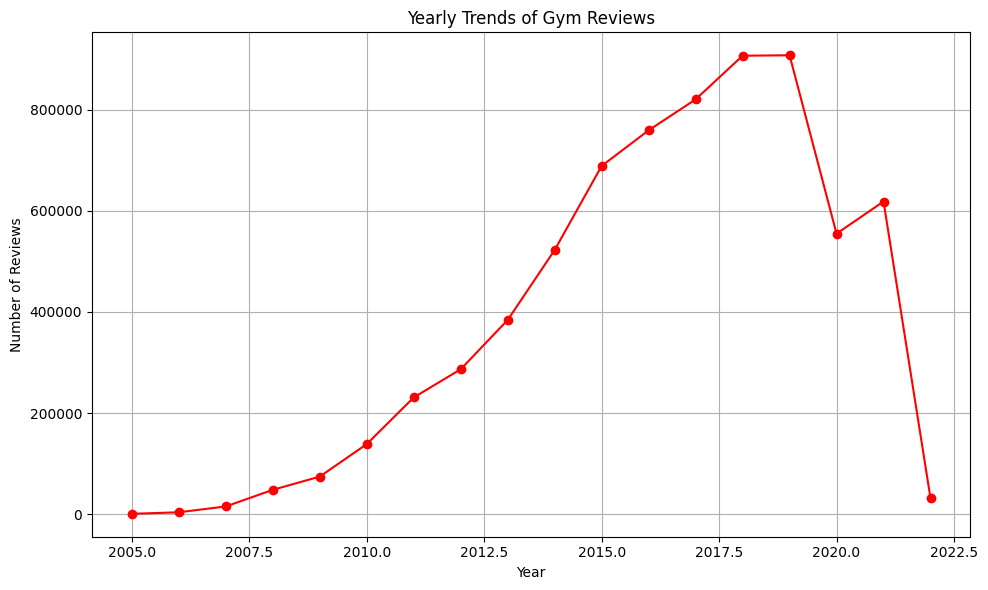

In [32]:
# Query 5: Yearly Trends of Gym Reviews
query5 = """
SELECT YEAR(CAST(date AS DATE)) AS review_year, COUNT(*) AS review_count
FROM review
GROUP BY review_year
ORDER BY review_year ASC
"""
yearly_trends_df = spark.sql(query5)

yearly_trends_pandas = yearly_trends_df.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(yearly_trends_pandas['review_year'], yearly_trends_pandas['review_count'], marker='o', color='red')
plt.title('Yearly Trends of Gym Reviews')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()


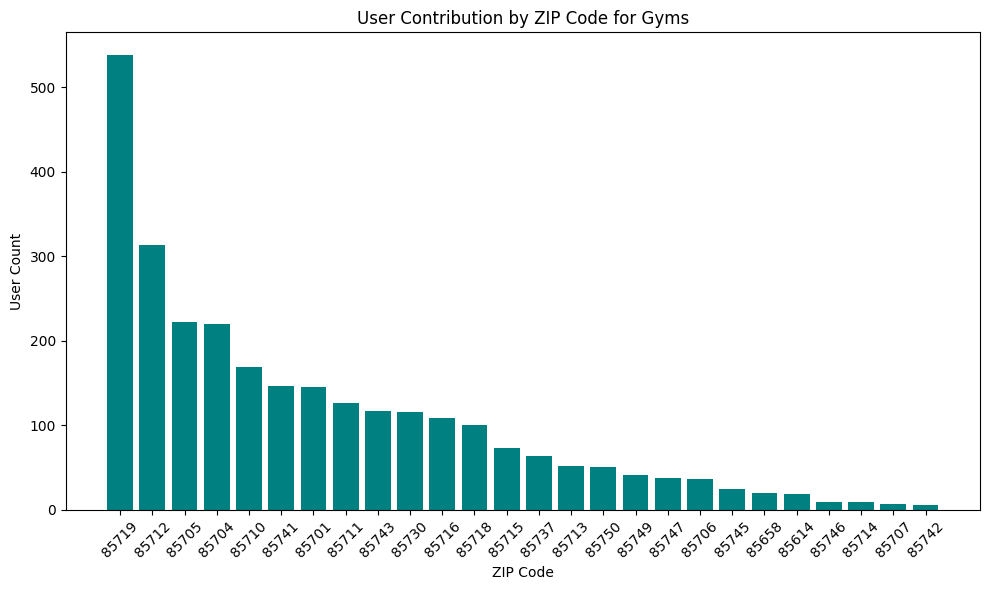

In [54]:
# Query 6: User Contribution by Gym ZIP Code
query6 = """
SELECT postal_code, COUNT(DISTINCT user_id) AS user_count
FROM gyms
JOIN review ON gyms.business_id = review.business_id
GROUP BY postal_code
ORDER BY user_count DESC
"""
zip_user_contribution_df = spark.sql(query6)

zip_user_contribution_pandas = zip_user_contribution_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(zip_user_contribution_pandas['postal_code'], zip_user_contribution_pandas['user_count'], color='teal')
plt.title('User Contribution by ZIP Code for Gyms')
plt.xlabel('ZIP Code')
plt.ylabel('User Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


24/11/24 02:38:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 02:38:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 02:38:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 02:38:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


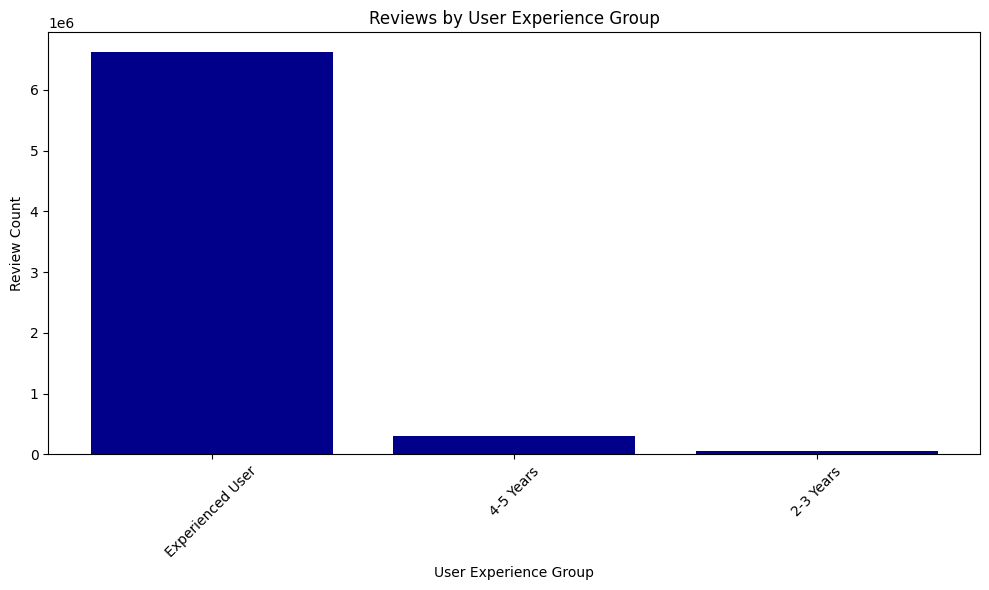

In [68]:
# Query 7: Reviews by User Experience Group
query7 = """
SELECT 
    CASE 
        WHEN year(CURRENT_DATE()) - year(yelping_since) BETWEEN 0 AND 1 THEN 'New User'
        WHEN year(CURRENT_DATE()) - year(yelping_since) BETWEEN 2 AND 3 THEN '2-3 Years'
        WHEN year(CURRENT_DATE()) - year(yelping_since) BETWEEN 4 AND 5 THEN '4-5 Years'
        ELSE 'Experienced User'
    END AS user_experience_group,
    COUNT(*) AS review_count
FROM review
JOIN user ON review.user_id = user.user_id
GROUP BY user_experience_group
ORDER BY review_count DESC
"""
user_experience_reviews_df = spark.sql(query7)

user_experience_reviews_pandas = user_experience_reviews_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(user_experience_reviews_pandas['user_experience_group'], user_experience_reviews_pandas['review_count'], color='darkblue')
plt.title('Reviews by User Experience Group')
plt.xlabel('User Experience Group')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [71]:
# Check the distinct values in the elite column to refine the CASE statement
query_check_elite = """
SELECT DISTINCT elite FROM user
"""
elite_values_df = spark.sql(query_check_elite)
elite_values_pandas = elite_values_df.toPandas()
print(elite_values_pandas)


                                                  elite
0     2010,2011,2012,2013,2014,2015,2016,2017,2018,2...
1                             2006,2018,2019,20,20,2021
2                    2011,2012,2014,2015,2016,2017,2018
3                                        2010,2011,2014
4     2008,2011,2012,2013,2014,2015,2016,2017,2018,2...
...                                                 ...
1351           2009,2012,2013,2017,2018,2019,20,20,2021
1352                                2011,2014,2015,2021
1353                                2009,2011,2015,2016
1354                     2014,2015,2016,2018,20,20,2021
1355                                     2013,2014,2019

[1356 rows x 1 columns]


24/11/24 02:44:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 02:44:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 02:44:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 02:44:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


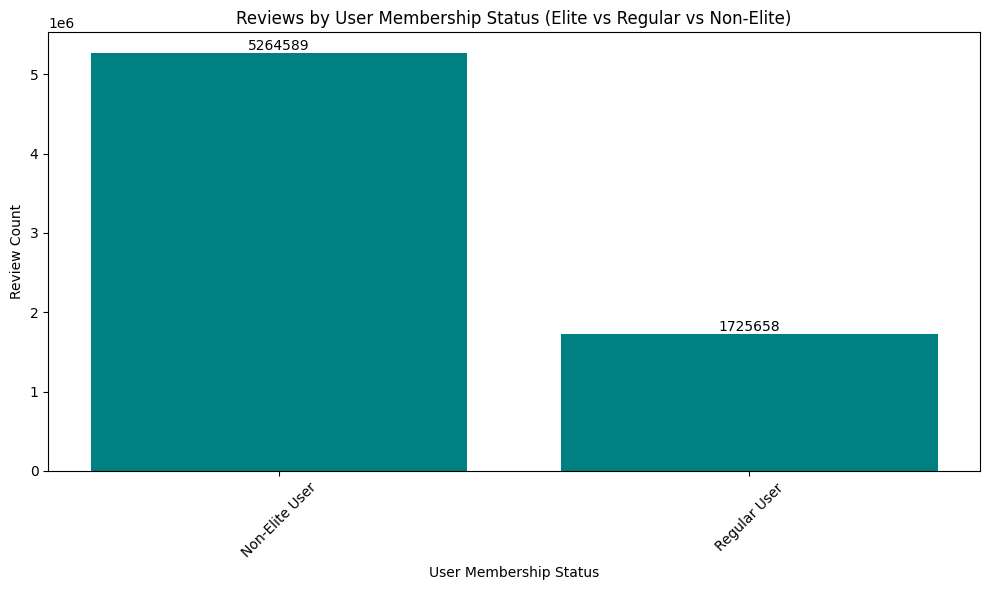

In [72]:
# Query 8: Reviews by User Membership status
query8 = """
SELECT 
    CASE 
        WHEN elite = 'Yelp Elite' THEN 'Elite User'
        WHEN elite IS NULL OR elite = '' THEN 'Non-Elite User'
        ELSE 'Regular User'
    END AS user_membership_status,
    COUNT(*) AS review_count
FROM review
JOIN user ON review.user_id = user.user_id
GROUP BY user_membership_status
ORDER BY review_count DESC
"""
membership_reviews_df = spark.sql(query8)

membership_reviews_pandas = membership_reviews_df.toPandas()

# Enhanced plot
plt.figure(figsize=(10, 6))
bars = plt.bar(membership_reviews_pandas['user_membership_status'], membership_reviews_pandas['review_count'], color='teal')

# Adding labels and title
plt.title('Reviews by User Membership Status (Elite vs Regular vs Non-Elite)')
plt.xlabel('User Membership Status')
plt.ylabel('Review Count')
plt.xticks(rotation=45)

# Adding value labels to the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, round(yval, 2), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()


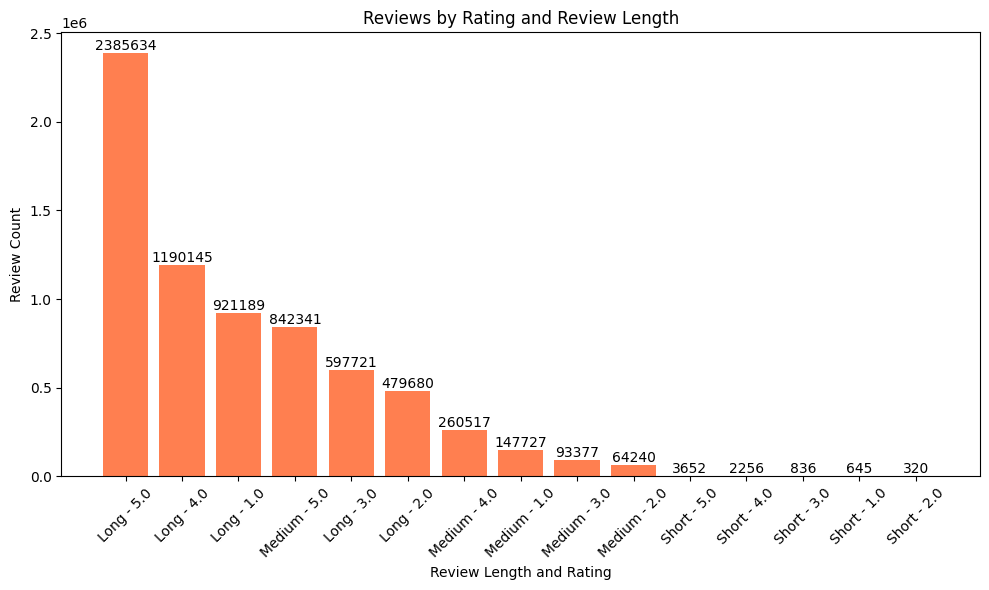

In [74]:
# Query 9: Reviews by Rating and Review Length
query9 = """
SELECT 
    CASE 
        WHEN LENGTH(review.text) < 50 THEN 'Short'
        WHEN LENGTH(review.text) BETWEEN 50 AND 200 THEN 'Medium'
        WHEN LENGTH(review.text) > 200 THEN 'Long'
        ELSE 'Unknown'
    END AS review_length,
    review.stars AS rating,
    COUNT(*) AS review_count
FROM review
GROUP BY review_length, rating
ORDER BY review_count DESC
"""
review_length_rating_df = spark.sql(query9)

review_length_rating_pandas = review_length_rating_df.toPandas()

# Enhanced plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    review_length_rating_pandas['review_length'] + " - " + review_length_rating_pandas['rating'].astype(str),
    review_length_rating_pandas['review_count'], 
    color='coral'
)

# Adding labels and title
plt.title('Reviews by Rating and Review Length')
plt.xlabel('Review Length and Rating')
plt.ylabel('Review Count')
plt.xticks(rotation=45)

# Adding value labels to the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, round(yval, 2), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()


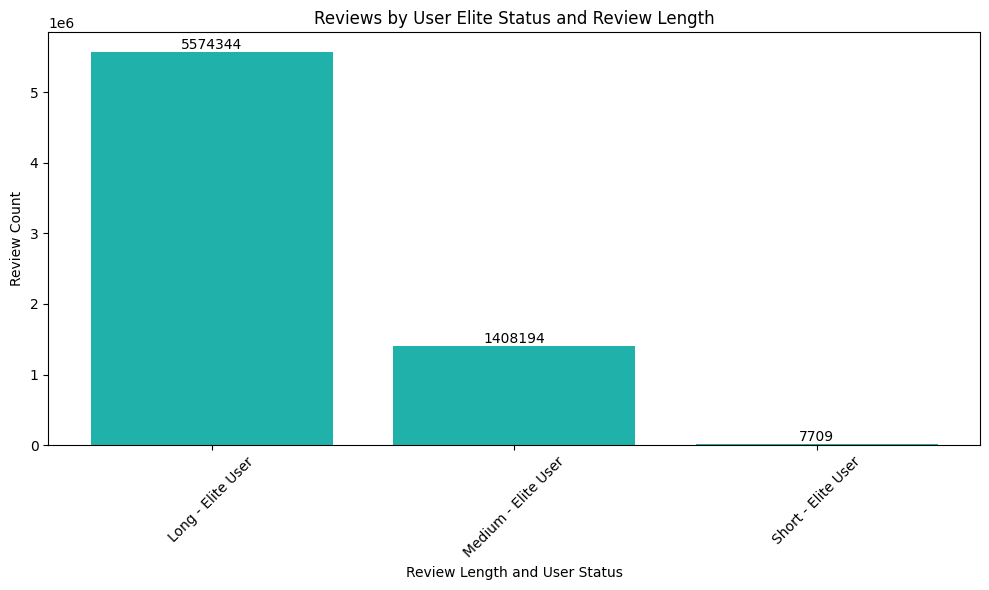

In [76]:
# Query 10: Reviews by User Elite status and Review Length
query10 = """
SELECT 
    CASE 
        WHEN LENGTH(review.text) < 50 THEN 'Short'
        WHEN LENGTH(review.text) BETWEEN 50 AND 200 THEN 'Medium'
        WHEN LENGTH(review.text) > 200 THEN 'Long'
        ELSE 'Unknown'
    END AS review_length,
    CASE
        WHEN user.elite IS NOT NULL THEN 'Elite User'
        ELSE 'Non-Elite User'
    END AS user_status,
    COUNT(*) AS review_count
FROM review
JOIN user ON review.user_id = user.user_id
GROUP BY review_length, user_status
ORDER BY review_count DESC
"""
review_length_status_df = spark.sql(query10)

review_length_status_pandas = review_length_status_df.toPandas()

# Enhanced plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    review_length_status_pandas['review_length'] + " - " + review_length_status_pandas['user_status'],
    review_length_status_pandas['review_count'], 
    color='lightseagreen'
)

# Adding labels and title
plt.title('Reviews by User Elite Status and Review Length')
plt.xlabel('Review Length and User Status')
plt.ylabel('Review Count')
plt.xticks(rotation=45)

# Adding value labels to the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, round(yval, 2), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

